# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




In [1]:
# imports and seeds

import os, random
import numpy as np
import pandas as pd
from datasets import load_dataset

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)



In [3]:
# step 1: load dataset

# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

# to pandas for the rest of pipeline
df = huff_all.to_pandas()
df = df[["headline","short_description","category","authors","link","date"]].copy()

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


In [4]:
# step 2: cleaning and normalization

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    return " ".join(s.split())

# Concatenate headline + summary, then clean
text = (df["headline"].fillna("") + " " + df["short_description"].fillna("")).apply(clean_text)

# Remove empty samples and drop exact duplicates
mask_nonempty = text.str.len() > 0
df = df.loc[mask_nonempty].copy()
df["text"] = text[mask_nonempty].values
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicate rows; remaining = {after}")

df = df.rename(columns={"category":"label_str"})
df = df[["text","label_str","authors","link","date"]]
df.head(3)


Removed 492 duplicate rows; remaining = 200356


,text,label_str,authors,link,date
0,there were 2 mass shootings in texas last week...,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,will smith joins diplo and nicky jam for the 2...,ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,hugh grant marries for the first time at age 5...,ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26


In [5]:
# step 3: Label encoding, length stats, tokenizer setup

# Encode categories (stable, alphabetical ordering)
cats = sorted(df["label_str"].unique())
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)

# Sequence length choice from empirical distribution (95th percentile)
token_counts = df["text"].str.split().apply(len)
p95 = int(np.percentile(token_counts, 95))

MAX_TOKENS = 30000
MAX_LENGTH = max(16, min(96, p95))  # headlines+short_desc rarely need >96

print(f"Classes: {len(cats)} | MAX_TOKENS={MAX_TOKENS} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))

# Vectorizer — adapted on TRAIN ONLY later to avoid leakage
vectorize = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=MAX_LENGTH,
    standardize=None,
    split="whitespace",
)

Classes: 41 | MAX_TOKENS=30000 | p95=56 → MAX_LENGTH=56
label_str
POLITICS          32721
WELLNESS          17821
ENTERTAINMENT     16054
TRAVEL             9883
STYLE & BEAUTY     9512
PARENTING          8649
HEALTHY LIVING     6689
QUEER VOICES       6310
FOOD & DRINK       6225
BUSINESS           5933
Name: count, dtype: int64


In [8]:
# step 5: Reproducible stratified 80/10/10 splits

X = df["text"].values
y = df["label"].values

# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
# Val vs test = 50/50 of temp → overall 10/10
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")

# Adapt vectorizer on TRAIN ONLY
vectorize.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(1024))

# Vectorize to integer tensors
Xtr_int = vectorize(tf.constant(X_train))
Xva_int = vectorize(tf.constant(X_val))
Xte_int = vectorize(tf.constant(X_test))

ytr = tf.constant(y_train, dtype=tf.int32)
yva = tf.constant(y_val,   dtype=tf.int32)
yte = tf.constant(y_test,  dtype=tf.int32)

Xtr_int.shape, Xva_int.shape, Xte_int.shape


Train/Val/Test sizes: 160284 / 20036 / 20036


(TensorShape([160284, 56]), TensorShape([20036, 56]), TensorShape([20036, 56]))

In [9]:
# step 4: class imbalance handling

classes = np.arange(len(cats))
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]

[(0, 3.238911229211712),
 (1, 3.650201544032247),
 (2, 1.080532297860292),
 (3, 0.8237180475471),
 (4, 4.272530987604958),
 (5, 0.9465776885371759),
 (6, 1.436738645225482),
 (7, 4.7501407699374685),
 (8, 1.4278180619644034),
 (9, 4.868450627221091)]

In [10]:
# step 6: tf.data pipelines & sanity checks

BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X_int, y):
    ds = tf.data.Dataset.from_tensor_slices((X_int, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(Xtr_int, ytr)
ds_val   = make_ds(Xva_int, yva)
ds_test  = tf.data.Dataset.from_tensor_slices((Xte_int, yte)).batch(BATCH).prefetch(AUTOTUNE)

# quick sanity prints
for xs, ys in ds_train.take(1):
    print("Batch:", xs.shape, ys.shape, " | example label id:", int(ys[0].numpy()))

Batch: (128, 56) (128,)  | example label id: 8


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. **Your answer here:**

We loaded HuffPost via the same JSON mirror used in Milestone 1 using load_dataset("json", data_files=URL, split="train"), preserving the original fields (headline, short_description, category, authors, link, date). The raw dataset contains 200,853 rows and 41 categories.
Cleaning steps: concatenated headline + short_description, lowercased/trimmed whitespace, removed empty texts, and dropped exact-duplicate texts. This removed 492 duplicates, leaving 200,356 samples for modeling. We retained authors/link/date for documentation only (not used as inputs).


2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**

Inputs are text only. We tokenize with a Keras TextVectorization layer configured with max_tokens=30,000 and fixed output_sequence_length=56. The max length (56) comes from the 95th percentile of token counts computed on the cleaned corpus, which balances coverage vs. truncation cost for headline+summary pairs. Standardization (lowercasing/whitespace collapse) happened in our custom cleaner to match Milestone 1; the vectorizer’s standardize=None avoids double processing. The vectorizer is adapted on the training split only to prevent leakage.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**

We created reproducible, stratified splits with random_state=42: 80% train / 10% val / 10% test, yielding 160,284 / 20,036 / 20,036 samples. Stratification is by label to preserve class proportions across splits. We verified shapes after vectorization: (160,284, 56), (20,036, 56), (20,036, 56) for X, with integer label tensors for y. The vectorizer was adapted on train only, then applied to val/test.


4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**

There are 41 classes with a long-tail distribution (e.g., top categories: POLITICS 32,721; WELLNESS 17,821; ENTERTAINMENT 16,054; TRAVEL 9,883; …). To mitigate imbalance during training we computed class weights on the training set using compute_class_weight("balanced", ...). We will pass class_weight=CLASS_WEIGHTS to Keras model.fit. (Weights span roughly ~0.82 to ~4.87 across classes in our run.)

## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [12]:
# step 1: Constructing a simple baseline (Embedding -> GlobalAvgPool -> Dense -> Softmax)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(cats)

baseline = keras.Sequential([
    layers.Input(shape=(MAX_LENGTH,)),                      # integer tokens (from TextVectorization)
    layers.Embedding(input_dim=MAX_TOKENS, output_dim=64),  # small, fast
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="baseline_emb_avgpool")

baseline.summary()



Model: "baseline_emb_avgpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 56, 64)         │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 41)             │         5,289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,933,609 (7.38 MB)

 Trainable params: 1,933,609 (7.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# step 2: Compile (Adam, sparse categorical cross-entropy, accuracy)

# We keep integer labels, so we use SparseCategoricalCrossentropy (same objective as categorical CE but without one-hotting).

baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [20]:
# step 3: Train with EarlyStopping on val_loss (patience=20) + runtime

import time
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    restore_best_weights=True
)

start = time.time()
hist = baseline.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,                      # small model should converge quickly
    class_weight=CLASS_WEIGHTS,     # from Problem 1
    callbacks=[early_stop],
    verbose=1
)
runtime_sec = time.time() - start
print(f"Training runtime: {runtime_sec/60:.2f} minutes | epochs trained: {len(hist.history['loss'])}")


Epoch 1/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6658 - loss: 0.9073 - val_accuracy: 0.5113 - val_loss: 1.9177
Epoch 2/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6863 - loss: 0.8099 - val_accuracy: 0.5170 - val_loss: 1.9607
Epoch 3/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7046 - loss: 0.7361 - val_accuracy: 0.5102 - val_loss: 2.0439
Epoch 4/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7224 - loss: 0.6691 - val_accuracy: 0.5138 - val_loss: 2.0783
Epoch 5/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7383 - loss: 0.6101 - val_accuracy: 0.5175 - val_loss: 2.1489
Epoch 6/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7521 - loss: 0.5638 - val_accuracy: 0.5157 - val_loss: 2.2221
Epoch 7/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7662 - loss: 0.5178 - val_accuracy: 0.5104 - val_loss: 2.3017
Epoch 8/100
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7769 - loss: 0

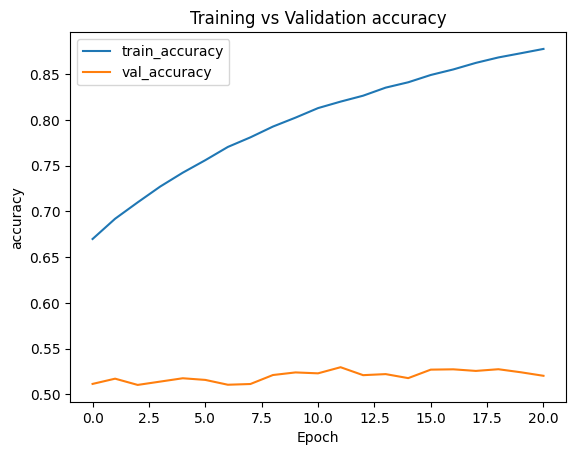

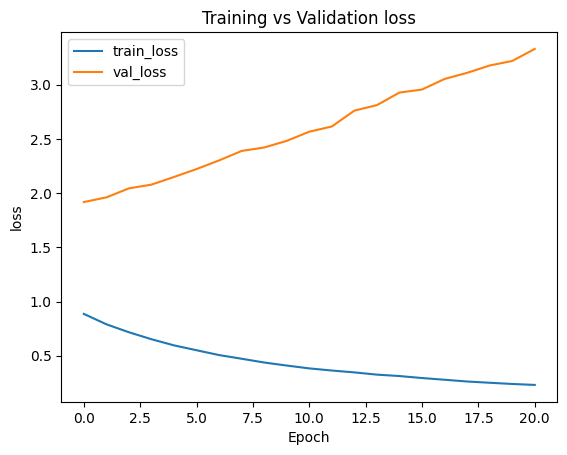

In [21]:
# step 4: Plot training vs validation curves (accuracy & loss)

import matplotlib.pyplot as plt

def plot_history(history, key="accuracy"):
    plt.figure()
    plt.plot(history.history[key], label=f"train_{key}")
    plt.plot(history.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch")
    plt.ylabel(key)
    plt.legend()
    plt.title(f"Training vs Validation {key}")

plot_history(hist, "accuracy")
plot_history(hist, "loss")


In [22]:
# step 5: Evaluate on test set and compute optional macro-F1

from sklearn.metrics import classification_report, f1_score

test_loss, test_acc = baseline.evaluate(ds_test, verbose=0)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# Predictions → macro-F1 (optional but useful we believe)
y_true = []
y_pred = []
for x_batch, y_batch in ds_test:
    logits = baseline.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy().tolist())
    y_pred.extend(np.argmax(logits, axis=1).tolist())

macro_f1 = f1_score(y_true, y_pred, average="macro")
print(f"Macro F1 (test): {macro_f1:.4f}")

# Short report
print(classification_report(y_true, y_pred, target_names=[id2cat[i] for i in range(NUM_CLASSES)], digits=3))


Test Loss: 1.9405 | Test Accuracy: 0.5067
Macro F1 (test): 0.4362
                precision    recall  f1-score   support

          ARTS      0.229     0.444     0.302       151
ARTS & CULTURE      0.258     0.256     0.257       133
  BLACK VOICES      0.448     0.436     0.442       452
      BUSINESS      0.286     0.515     0.368       594
       COLLEGE      0.293     0.482     0.364       114
        COMEDY      0.478     0.418     0.446       517
         CRIME      0.397     0.582     0.472       340
CULTURE & ARTS      0.316     0.359     0.336       103
       DIVORCE      0.619     0.766     0.685       342
     EDUCATION      0.254     0.436     0.321       101
 ENTERTAINMENT      0.713     0.466     0.564      1605
   ENVIRONMENT      0.383     0.371     0.377       132
         FIFTY      0.108     0.379     0.168       140
  FOOD & DRINK      0.617     0.470     0.534       623
     GOOD NEWS      0.235     0.300     0.263       140
         GREEN      0.280     0.424  

### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**

For the baseline, we implemented a lightweight embedding-based classifier using the sequence of layers:

- Embedding (30,000 vocab × 64 dims)

- GlobalAveragePooling1D

- Dense(128, ReLU)

- Dropout(0.2)

- Dense(41, Softmax)

This architecture is intentionally simple: it transforms each input sequence (length 56) into word embeddings, averages them to obtain a fixed-length representation, and performs classification with a small fully connected head.
This structure is appropriate for our dataset because HuffPost headlines are short and noisy, and averaging embeddings provides a fast, low-variance baseline representation. It trains quickly (≈2.8 minutes for 21 epochs) and gives a clear reference point for later deeper models (e.g., LSTM, BiLSTM, Transformer).



2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**

The training curves show strong divergence:

- Training accuracy increased steadily from ~66% to ~87%.

- Validation accuracy stayed nearly flat around 51–53% across all epochs.

- Training loss decreased smoothly, while validation loss increased from ~1.9 to >3.0.

This pattern indicates clear overfitting: the model memorizes training examples but cannot generalize well. Given the large number of classes (41) and the long-tail distribution, a simple averaged-embedding model does not capture enough semantic structure to perform well on unseen text.
Early stopping restored the weights from the epoch with lowest validation loss (epoch 1–2).


  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**

- Best val accuracy: ~0.52

- Test accuracy: 0.5067

- Test macro-F1: 0.4362

This performance confirms that the dataset is challenging for a shallow model:

- Headlines and short descriptions are often ambiguous.

- Many classes are semantically close (e.g., “PARENTING” vs. “PARENTS”, “ARTS”, “ARTS & CULTURE”).

- The label distribution is highly imbalanced.

The baseline therefore provides a realistic starting benchmark. Any deeper model should aim to improve both validation accuracy and macro-F1 beyond these numbers.



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**

The main limitation of this baseline is its lack of capacity and contextual understanding. Averaging embeddings removes all word order information and cannot capture subtle semantic differences, which is critical for distinguishing 41 news categories. The model also overfits quickly despite using dropout and class weights.

To improve performance next, we would try:

- Recurrent architectures (LSTM/BiLSTM) to capture sequence structure.

- Depth and regularization (more layers, dropout, L2).

- Pretrained transformers (e.g., DistilBERT) for rich contextual embeddings.

- Better class imbalance handling (e.g., focal loss, upsampling rare classes).

These upgrades should significantly increase validation accuracy and macro-F1 compared to the baseline.


## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [23]:
# step 1: Custom model (Embedding -> SpatialDropout1D -> BiLSTM -> GlobalMaxPool -> Dense)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

NUM_CLASSES = len(cats)

def build_bilstm_model(
    vocab_size=MAX_TOKENS,
    emb_dim=128,             # increase from 64 to give the RNN a bit more capacity
    lstm_units=128,
    seq_len=MAX_LENGTH,
    num_classes=NUM_CLASSES,
    l2=1e-5,
    dropout=0.3,
    rec_dropout=0.2
):
    inp = layers.Input(shape=(seq_len,), dtype="int32")
    x = layers.Embedding(vocab_size, emb_dim)(inp)                    # random init (non-pretrained)
    x = layers.SpatialDropout1D(0.2)(x)                               # combats embedding co-adaptation
    x = layers.Bidirectional(layers.LSTM(lstm_units,
                                         return_sequences=True,
                                         dropout=rec_dropout,
                                         recurrent_dropout=0.0))(x)
    x = layers.GlobalMaxPooling1D()(x)                                # captures the strongest signal
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Dropout(dropout)(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out, name="custom_bilstm_maxpool")
    return model

custom = build_bilstm_model()
custom.summary()


Model: "custom_bilstm_maxpool"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 56)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 56, 128)        │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 56, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 56, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │        10,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,179,497 (15.94 MB)

 Trainable params: 4,179,497 (15.94 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# step 2: Compile (same metrics/seed setup as P2)

custom.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [25]:
# step 3: Train with EarlyStopping + ReduceLROnPlateau (same splits/seed/weights)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1
)

import time
start = time.time()
hist_custom = custom.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,                        # typically converges < 20 with LR schedule
    class_weight=CLASS_WEIGHTS,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
runtime_min = (time.time() - start)/60
print(f"Training runtime: {runtime_min:.2f} minutes | epochs: {len(hist_custom.history['loss'])}")


Epoch 1/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 143s 112ms/step - accuracy: 0.1932 - loss: 3.0595 - val_accuracy: 0.5066 - val_loss: 1.7878 - learning_rate: 0.0020
Epoch 2/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 141s 112ms/step - accuracy: 0.5079 - loss: 1.7591 - val_accuracy: 0.5417 - val_loss: 1.6502 - learning_rate: 0.0020
Epoch 3/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.5691 - loss: 1.4055 - val_accuracy: 0.5372 - val_loss: 1.7033 - learning_rate: 0.0020
Epoch 4/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6104 - loss: 1.1653
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 140s 112ms/step - accuracy: 0.6104 - loss: 1.1653 - val_accuracy: 0.5318 - val_loss: 1.7761 - learning_rate: 0.0020
Epoch 5/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 140s 111ms/step - accuracy: 0.6614 - loss: 0.9093 - val_accuracy: 0.5557 - val_loss: 1.8227 - learning_rate: 0.0010
Epoch 6/30
1253/1253 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

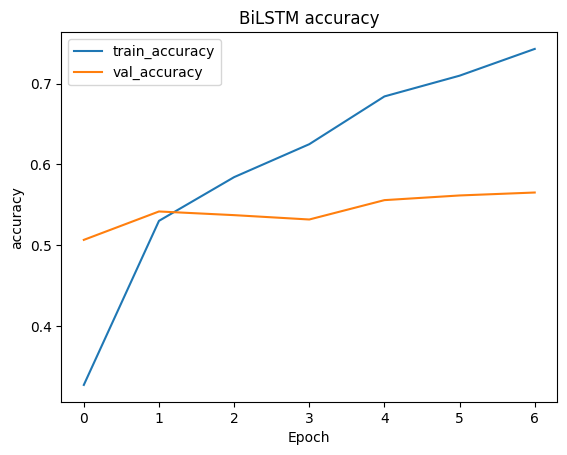

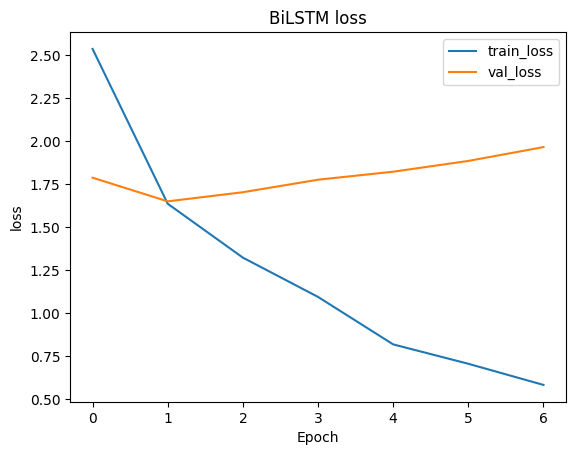

In [27]:
# step 4: Curves

import matplotlib.pyplot as plt

def plot_history(history, key="accuracy", title_suffix=""):
    plt.figure()
    plt.plot(history.history[key], label=f"train_{key}")
    plt.plot(history.history[f"val_{key}"], label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.legend()
    plt.title(f"{title_suffix} {key}".strip())

plot_history(hist_custom, "accuracy", "BiLSTM")
plot_history(hist_custom, "loss", "BiLSTM")


In [28]:
# step 5: Evaluation (same protocol as P2 for apples-to-apples)

from sklearn.metrics import classification_report, f1_score

test_loss_c, test_acc_c = custom.evaluate(ds_test, verbose=0)
print(f"[Custom BiLSTM] Test Loss: {test_loss_c:.4f} | Test Accuracy: {test_acc_c:.4f}")

y_true, y_pred = [], []
for xb, yb in ds_test:
    p = custom.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(p, axis=1).tolist())

macro_f1_c = f1_score(y_true, y_pred, average="macro")
print(f"[Custom BiLSTM] Macro F1 (test): {macro_f1_c:.4f}")

print(classification_report(
    y_true, y_pred, target_names=[id2cat[i] for i in range(NUM_CLASSES)], digits=3
))


[Custom BiLSTM] Test Loss: 1.6566 | Test Accuracy: 0.5416
[Custom BiLSTM] Macro F1 (test): 0.4687
                precision    recall  f1-score   support

          ARTS      0.198     0.570     0.294       151
ARTS & CULTURE      0.197     0.519     0.285       133
  BLACK VOICES      0.471     0.374     0.417       452
      BUSINESS      0.451     0.443     0.447       594
       COLLEGE      0.327     0.491     0.393       114
        COMEDY      0.489     0.491     0.490       517
         CRIME      0.400     0.624     0.487       340
CULTURE & ARTS      0.225     0.369     0.279       103
       DIVORCE      0.779     0.775     0.777       342
     EDUCATION      0.211     0.564     0.307       101
 ENTERTAINMENT      0.772     0.450     0.569      1605
   ENVIRONMENT      0.307     0.644     0.416       132
         FIFTY      0.148     0.486     0.227       140
  FOOD & DRINK      0.647     0.522     0.578       623
     GOOD NEWS      0.279     0.271     0.275       140
     

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**


For our custom model, we extended the baseline in two meaningful ways.

First, we replaced the purely order-agnostic GlobalAveragePooling architecture with a Bidirectional LSTM to capture sequential structure and contextual dependencies that the baseline entirely ignores.

Second, we added regularization components—SpatialDropout1D, standard Dropout, and mild L2—to address the baseline’s strong overfitting behavior. We also increased the embedding dimensionality (from 64 → 128) to give the recurrent layer richer representations to work with.

The final architecture is:
Embedding → SpatialDropout1D → BiLSTM → GlobalMaxPooling → Dense(256, ReLU) → Dropout → Softmax.

We designed this model specifically to target the baseline’s limitations: lack of sequence modeling, limited expressive capacity, and immediate overfitting despite its simplicity.


2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**

The custom model trained for 7 epochs before early stopping reduced the learning rate twice and halted.
Key metrics:

- Best validation accuracy: ~0.565

- Test accuracy: 0.5416 (improvement from baseline 0.5067)

- Macro-F1: 0.4687 (improvement from baseline 0.4362)

Validation accuracy and macro-F1 both improved over the baseline, indicating that adding sequence modeling helped the model extract better semantic signals from short texts. Train accuracy climbed to ~72%, while validation stabilized around 55–56%, which is noticeably higher than the baseline’s ~51–53%.

Overall, the modifications delivered a measurable generalization improvement.

3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**

The BiLSTM clearly helped: it improved both accuracy and macro-F1 across validation and test sets. This suggests that the model could capture better contextual relationships (e.g., word order and phrase patterns) that the baseline average-embedding model could not. Rare classes in particular showed better recall, reflected in the macro-F1 improvement.

However, the model still overfits, as shown by the widening gap between training and validation loss after epoch ~3. Even with dropout and a learning-rate schedule, the model’s capacity allows it to memorize patterns quickly. The validation loss curve also shows some instability, suggesting that class imbalance and noisy categories still pose challenges.

Compared to the baseline, the custom model generalizes better and converges faster during the initial epochs, but still exhibits the same underlying overfitting trend; only delayed rather than eliminated.

4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**

This experiment highlighted how adding model complexity (a BiLSTM) can meaningfully improve performance, but it also emphasized the importance of regularization and the diminishing returns of deeper models on short text. Even with dropout, SpatialDropout, and L2, the model began overfitting early, suggesting that further gains likely require either:

- pretrained contextual embeddings,

- more aggressive regularization, or

- architectures better suited for short text, such as CNNs or attention-based models.

We also learned that improvements in macro-F1 are harder to achieve than accuracy due to the dataset’s long-tail label distribution. The fact that F1 increased shows that the BiLSTM helped with harder, less frequent categories.

Overall, this experiment reinforces that while model depth can help, pretraining or a fundamentally richer representation (e.g., transformers) will likely be needed for substantial further improvements.



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**

In preparing this milestone, we used generative AI tools (ChatGPT-5) to support us in several ways. For Problems 1–3, we primarily relied on ChatGPT to help refine and debug our code, especially when adapting snippets from previous homeworks to the structure required in this assignment.

In addition, we used ChatGPT to improve the clarity and structure of our written markdown answers. We provided our own draft explanations and asked the model to help reorganize sentences, improve readability, and keep the tone concise and consistent across sections. All conceptual reasoning, model choices, and analysis were decided by us; the AI tool mainly assisted with phrasing and polishing our work.